mse:  18.965279947916667


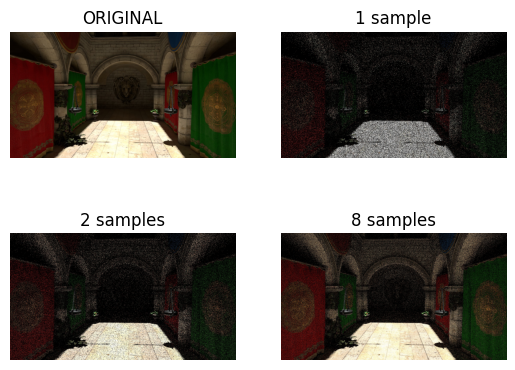

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

images = [
    cv2.cvtColor(cv2.imread('baseline_data/baseline_img_denoised.jpg'), cv2.COLOR_BGR2RGB), 
    cv2.cvtColor(cv2.imread('baseline_data/baseline_img_1_sample.jpg'), cv2.COLOR_BGR2RGB), 
    cv2.cvtColor(cv2.imread('baseline_data/baseline_img_2_samples.jpg'), cv2.COLOR_BGR2RGB), 
    cv2.cvtColor(cv2.imread('baseline_data/baseline_img_8_samples.jpg'), cv2.COLOR_BGR2RGB) 
]

images_MF = list(map(lambda img: cv2.medianBlur(img, 5), images))
images_NLM = list(map(lambda img: cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21), images))

mse = np.mean(cv2.absdiff(images[0], images_MF[0]) ** 2)
print("mse: ", mse)

plt.subplot(221),plt.imshow(images[0]),plt.title('ORIGINAL'),plt.axis('off')
plt.subplot(222),plt.imshow(images[1]),plt.title('1 sample'),plt.axis('off')
plt.subplot(223),plt.imshow(images[2]),plt.title('2 samples'),plt.axis('off')
plt.subplot(224),plt.imshow(images[3]),plt.title('8 samples'),plt.axis('off')
plt.show()